Differenzen für Szenario Scenario1: 1     12.731658
2     30.821550
3     -4.289053
4     11.219356
5     20.959325
6     29.400375
7    -12.923747
8     35.443727
9      4.254730
10   -19.278714
11    16.937170
12   -11.592747
13    14.417150
14    11.036740
15    39.630386
16    12.303575
17     7.271780
18     4.348450
19    20.399162
20    26.234308
21    38.482689
22    36.363060
23    21.101102
24    -1.574924
dtype: float64
Differenzen für Szenario Scenario2: 1     55.620949
2      8.717702
3     -4.289053
4     11.219356
5     -4.661963
6    -23.099685
7     11.665525
8      8.965185
9      4.254730
10     9.849401
11   -10.468257
12    11.808680
13    14.417150
14    34.226773
15    39.630386
16    12.303575
17     7.271780
18   -23.481731
19    20.399162
20   -14.722570
21    20.181567
22    19.313459
23    21.101102
24    38.852625
dtype: float64
Differenzen für Szenario Scenario3: 1     12.731658
2    -13.386146
3    -38.628091
4     11.219356
5     20.959325
6     29.40037

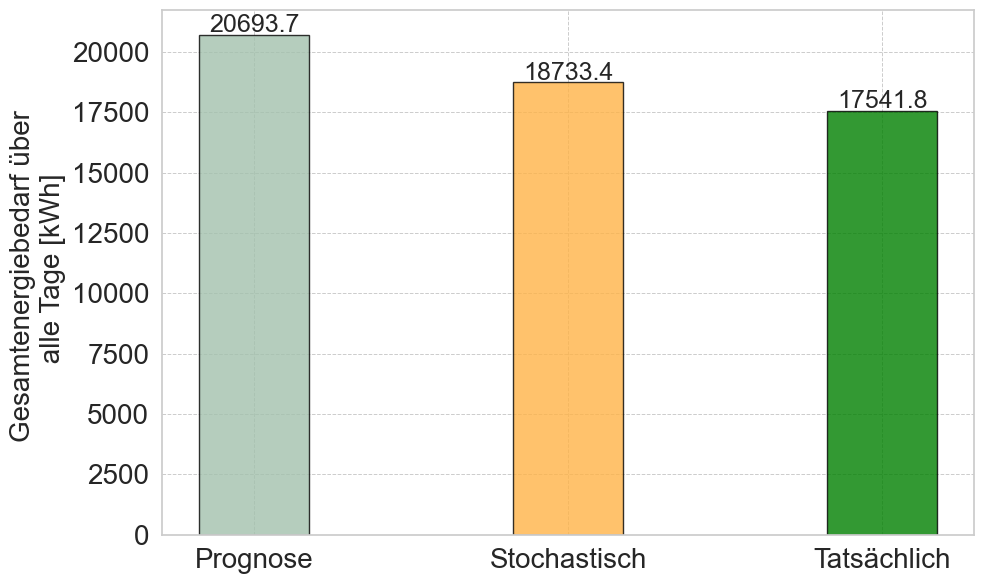

3


In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load configuration from config.json
with open('../models/config.json', 'r') as f:
    config = json.load(f)

postprocess = config['postprocessing']

# Pfad zum Verzeichnis für die Dateien
INPUT_PATH_HD = postprocess['input_path_hd']

externer_pfad = "C:/Users/paul/Nextcloud/99_MATEX/MATEX/Inhalt/Abbildungen/plots"
os.makedirs(externer_pfad, exist_ok=True)


dates = ['20230316','20230409', '20230410', '20230501', '20230515', '20230619', '20230622', '20230709', '20230710']

# Output path for plots (create if doesn't exist)
OUTPUT_PATH = 'output_plots'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

def process_date(date):
    start_date = date
    end_date = date

    # Pfade zu den Dateien
    actual_hd_file = f'{INPUT_PATH_HD}/actual_heat_demand_{start_date}_to_{end_date}_day.json'
    forecast_hd_file = f'{INPUT_PATH_HD}/heat_demand_{start_date}_to_{end_date}_day.json'
    scenarios_hd_file = f'{INPUT_PATH_HD}/reduced_heat_demand_scenarios_{start_date}_to_{end_date}_day.json'
    weighted_hd_file = f'{INPUT_PATH_HD}/weighted_heat_demand/weighted_heat_demand_{start_date}.json'

    # Einlesen der prognostizierten Wärmeanforderung
    with open(forecast_hd_file, 'r') as f:
        forecast_data = json.load(f)
    forecast_hd_values = forecast_data['heat_demand']
    forecast_hd_series = pd.Series({int(k): float(v) for k, v in forecast_hd_values.items()})
    forecast_hd_series = forecast_hd_series.sort_index()

    # Berechne die prognostizierte Gesamtwärmeanforderung
    total_forecast_hd = forecast_hd_series.sum()

    # Einlesen der Wärmeanforderungen der Szenarien
    with open(scenarios_hd_file, 'r') as f:
        scenarios_data = json.load(f)

    # Optional: Einlesen der tatsächlichen Wärmeanforderung (falls vorhanden)
    actual_hd_available = False
    try:
        with open(actual_hd_file, 'r') as f:
            actual_data = json.load(f)
        actual_hd_values = actual_data['heat_demand']
        actual_hd_series = pd.Series({int(k): float(v) for k, v in actual_hd_values.items()})
        actual_hd_series = actual_hd_series.sort_index()
        total_actual_hd = actual_hd_series.sum()
        actual_hd_available = True
    except FileNotFoundError:
        print(f"Keine tatsächliche Wärmeanforderung für {date} vorhanden.")

    # Optional: Einlesen der gewichteten Wärmeanforderung (weighted heat demand)
    weighted_hd_available = False
    try:
        with open(weighted_hd_file, 'r') as f:
            weighted_data = json.load(f)
        weighted_hd_values = weighted_data['heat_demand']
        weighted_hd_series = pd.Series({int(k): float(v) for k, v in weighted_hd_values.items()})
        weighted_hd_series = weighted_hd_series.sort_index()
        total_weighted_hd = weighted_hd_series.sum()
        weighted_hd_available = True
    except FileNotFoundError:
        print(f"Keine gewichtete Wärmeanforderung für {date} vorhanden.")
        total_weighted_hd = None

    # Berechnung der Differenzen und der gewichteten Gesamtwärmedifferenzen
    weighted_differences = []
    scenario_names = []
    total_differences = []
    probabilities = []

    for scenario_name, scenario_info in scenarios_data.items():
        probability = scenario_info['Probability']
        probabilities.append(probability)
        scenario_names.append(scenario_name)
        # Entferne 'Probability' aus dem Dictionary, um die stündlichen Wärmeanforderungen zu erhalten
        scenario_hd_values = {int(k): float(v) for k, v in scenario_info.items() if k != 'Probability'}
        scenario_hd_series = pd.Series(scenario_hd_values).sort_index()
        # Berechne die stündlichen Differenzen zur Prognose
        differences_series = forecast_hd_series - scenario_hd_series
        # Summiere die Differenzen über alle Stunden
        print(f"Differenzen für Szenario {scenario_name}: {differences_series}")
        total_difference = differences_series.sum()
        total_differences.append(total_difference)
        # Berechne die gewichtete Differenz
        weighted_difference = probability * total_difference
        weighted_differences.append(weighted_difference)
    
    print(f"Weighted differences: {weighted_differences}")
    # Berechnung der erwarteten Gesamtwärmedifferenz
    expected_total_difference = sum(weighted_differences)
    # Berechnung der erwarteten Gesamtwärmeanforderung des stochastischen Modells
    expected_total_hd = total_forecast_hd - expected_total_difference

    # Ausgabe der Ergebnisse
    print(f"\nDatum: {date}")
    print(f"Prognostizierte Gesamtwärmeanforderung: {total_forecast_hd:.2f} kWh")
    print(f"Erwartete Gesamtwärmedifferenz: {expected_total_difference:.2f} kWh")
    print(f"Erwartete Gesamtwärmeanforderung (Stochastisches Modell): {expected_total_hd:.2f} kWh")

    if weighted_hd_available:
        print(f"Gewichtete Gesamtwärmeanforderung: {total_weighted_hd:.2f} kWh")

    if actual_hd_available:
        print(f"Tatsächliche Gesamtwärmeanforderung: {total_actual_hd:.2f} kWh")

    # Überprüfung der Summe der Wahrscheinlichkeiten
    total_probability = sum(probabilities)
    print(f"Summe der Wahrscheinlichkeiten: {total_probability:.4f}")

    # Tabelle mit den Szenarien und ihren Gesamtwärmedifferenzen
    scenarios_df = pd.DataFrame({
        'Szenario': scenario_names,
        'Wahrscheinlichkeit': probabilities,
        'Gesamtwärmedifferenz [kWh]': total_differences,
        'Gewichtete Differenz [kWh]': weighted_differences
    })
    print("\nSzenarien und ihre Gesamtwärmedifferenzen:")
    print(scenarios_df)

    # Modelle und ihre Gesamtwärmeanforderungen
    models = ['Prognose', 'Stochastisch']
    total_hds = [total_forecast_hd, expected_total_hd]

    if actual_hd_available:
        models.append('Tatsächlich')
        total_hds.append(total_actual_hd)

    # Seaborn-Theme aktivieren
    sns.set_theme(style="whitegrid")
    
    # Neuer Plot erstellen
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(models, total_hds, color=['blue', 'orange', 'green'][:len(models)], edgecolor='black', width=0.35, alpha=0.8)
    ax.set_ylabel('Gesamtwärmeanforderung [kWh]', fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_title(f'Wärmeanforderungen für {date}', fontsize=20)

    # Werte über den Balken anzeigen
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

    # Gitterlinien anpassen
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7)
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7)

    plt.tight_layout()
    
    plot_name = f"waermebedarf_{date}.png"
    
    # Externer Pfad
    extern = os.path.join(externer_pfad, plot_name)
    #plt.savefig(extern, dpi=300, bbox_inches='tight')
    
    # Interner Pfad
    intern = f'{OUTPUT_PATH}/waermebedarf_{date}.png'
    #plt.savefig(intern, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory

    # Rückgabe der Ergebnisse
    return {
        'date': date,
        'total_forecast_hd': total_forecast_hd,
        'expected_total_hd': expected_total_hd,
        'total_weighted_hd': total_weighted_hd,
        'total_actual_hd': total_actual_hd if actual_hd_available else None,
        'scenarios_df': scenarios_df
    }

# Hauptprogramm
results = []

for date in dates:
    result = process_date(date)
    results.append(result)

# Zusammenfassung der Ergebnisse
summary_data = {
    'date': [],
    'total_forecast_hd': [],
    'expected_total_hd': [],
    'total_weighted_hd': [],
    'total_actual_hd': []
}

for result in results:
    summary_data['date'].append(result['date'])
    summary_data['total_forecast_hd'].append(result['total_forecast_hd'])
    summary_data['expected_total_hd'].append(result['expected_total_hd'])
    summary_data['total_weighted_hd'].append(result['total_weighted_hd'])
    summary_data['total_actual_hd'].append(result['total_actual_hd'])

summary_df = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(summary_df)

# Plot für die Summe aller simulierten Tage erstellen
summary_totals = {
    'Modelle': ['Prognose', 'Stochastisch'],
    'Gesamtenergiebedarf [kWh]': [
        summary_df['total_forecast_hd'].sum(),
        summary_df['expected_total_hd'].sum()
    ]
}

if summary_df['total_actual_hd'].notna().any():
    summary_totals['Modelle'].append('Tatsächlich')
    summary_totals['Gesamtenergiebedarf [kWh]'].append(summary_df['total_actual_hd'].sum())

summary_totals_df = pd.DataFrame(summary_totals)

# Farben der Boxplots verwenden (after summary_totals_df creation)
colors = ['#A3C1AD', '#FFB347', 'green'][:len(summary_totals_df)]



# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(summary_totals_df['Modelle'], summary_totals_df['Gesamtenergiebedarf [kWh]'], color=colors, edgecolor='black', width=0.35, alpha=0.8)
ax.set_ylabel('Gesamtenergiebedarf über \n alle Tage [kWh]', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
#ax.set_title('Gesamtenergiebedarf aller simulierten Tage', fontsize=16)

# Werte über den Balken anzeigen
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 15),
                textcoords="offset points",
                ha='center', va='top', fontsize=18)

# Gitterlinien anpassen
ax.yaxis.grid(True, linestyle='--', linewidth=0.7)
ax.xaxis.grid(True, linestyle='--', linewidth=0.7)

plt.tight_layout()
# Plot speichern
plot_name = f"gesamtwaermebedarf.png"
    
# Externer Pfad
extern = os.path.join(externer_pfad, plot_name)
plt.savefig(extern, dpi=300, bbox_inches='tight')
    
# Interner Pfad
intern = f'{OUTPUT_PATH}/gesamtwaermebedarf.png'
plt.savefig(intern, dpi=300, bbox_inches='tight')
#plt.close(fig)  # Close the figure to free memory
plt.show()
print(len(summary_totals_df))



Zusammenfassung der Ergebnisse:
       date  total_forecast_hd  expected_total_hd  total_weighted_hd  \
0  20230316        4688.944218        4467.597673        4467.597673   
1  20230409        3742.442574        3529.691706        3529.691706   
2  20230410        2971.934007        2735.563330        2735.563330   
3  20230501        2590.495308        2383.715652        2383.715652   
4  20230515        1631.996032        1405.921841        1405.921841   
5  20230619        1281.489678        1032.282538        1032.282538   
6  20230622        1250.308403         995.982773         995.982773   
7  20230709        1291.667771        1097.990101        1097.990101   
8  20230710        1244.403190        1084.671763        1084.671763   

   total_actual_hd  
0      3757.120902  
1      2799.937546  
2      2410.429211  
3      2395.433372  
4      1659.587530  
5      1174.760855  
6      1105.162519  
7      1146.737521  
8      1092.645851  

Fehlerdaten:
        date          

C:\Users\paul\AppData\Local\Temp\ipykernel_25752\3186494667.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


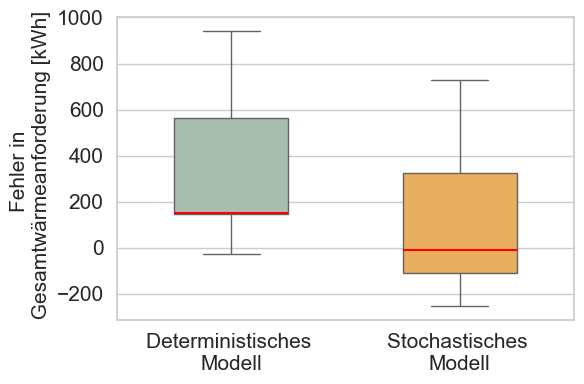

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn-Stil und -Farbschema anpassen
sns.set_theme(style="whitegrid", palette="pastel")

# Zusammenfassung der Ergebnisse
summary_data = {
    'date': [],
    'total_forecast_hd': [],
    'expected_total_hd': [],
    'total_weighted_hd': [],
    'total_actual_hd': []
}

for result in results:
    summary_data['date'].append(result['date'])
    summary_data['total_forecast_hd'].append(result['total_forecast_hd'])
    summary_data['expected_total_hd'].append(result['expected_total_hd'])
    summary_data['total_weighted_hd'].append(result['total_weighted_hd'])
    summary_data['total_actual_hd'].append(result['total_actual_hd'])

summary_df = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(summary_df)
summary_df.to_csv(f'{OUTPUT_PATH}/zusammenfassung_ergebnisse.csv', index=False)

# Berechnung der täglichen Fehler, falls tatsächlicher Wärmebedarf verfügbar ist
error_data = {
    'date': [],
    'Modell': [],
    'Fehler [kWh]': []
}

for result in results:
    date = result['date']
    total_actual_hd = result['total_actual_hd']
    if total_actual_hd is not None:
        # Fehler des deterministischen Modells
        error_deterministic = result['total_forecast_hd'] - total_actual_hd
        error_data['date'].append(date)
        error_data['Modell'].append('Deterministisches \nModell')
        error_data['Fehler [kWh]'].append(error_deterministic)

        # Fehler des stochastischen Modells
        error_stochastic = result['expected_total_hd'] - total_actual_hd
        error_data['date'].append(date)
        error_data['Modell'].append('Stochastisches \nModell')
        error_data['Fehler [kWh]'].append(error_stochastic)

# Erstellen eines DataFrames mit den Fehlerdaten
error_df = pd.DataFrame(error_data)
print("\nFehlerdaten:")
print(error_df)
error_df.to_csv(f'{OUTPUT_PATH}/fehlerdaten.csv', index=False)

# Erstellung des Boxplots
plt.figure(figsize=(6, 4))  # Angepasste Figurgröße für einen weniger breiten Plot

# Boxplot mit angepassten Eigenschaften erstellen
sns.boxplot(
    x='Modell',
    y='Fehler [kWh]',
    data=error_df,
    palette=['#A3C1AD', '#FFB347'],  # Dezente Farbauswahl
    width=0.5,  # Schmalere Boxen
    linewidth=1 , # Dünnere Linien für die Boxen
    medianprops=dict(color='red', linewidth=1.5) 
)

# Anpassung des Plots
#plt.title('Verteilung der täglichen Fehler der Modelle', fontsize=12)
plt.xlabel('', fontsize=15)
plt.ylabel('Fehler in \n Gesamtwärmeanforderung [kWh]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Dünnere Linie bei y=0

# Überflüssige Ränder entfernen
plt.tight_layout()
plot_name = f"fehler_boxplot_gesamtwaermebedarf.png"
    
# Externer Pfad
extern = os.path.join(externer_pfad, plot_name)
#plt.savefig(extern, dpi=300, bbox_inches='tight')
    
# Interner Pfad
# Plot speichern
plot_filename = f'{OUTPUT_PATH}/fehler_boxplot_gesamtwaermebedarf.png'
#plt.savefig(plot_filename, dpi=300)  # Höhere DPI für bessere Auflösung
#plt.close()
plt.show()


In [32]:
# Vorbereitung der Daten für das Streudiagramm
scatter_data = {
    'date': [],
    'Modell': [],
    'Vorhergesagter Wärmebedarf [kWh]': [],
    'Tatsächlicher Wärmebedarf [kWh]': []
}

for result in results:
    date = result['date']
    total_actual_hd = result['total_actual_hd']
    if total_actual_hd is not None:
        # Deterministisches Modell
        scatter_data['date'].append(date)
        scatter_data['Modell'].append('Deterministisches \nModell')
        scatter_data['Vorhergesagter Wärmebedarf [kWh]'].append(result['total_forecast_hd'])
        scatter_data['Tatsächlicher Wärmebedarf [kWh]'].append(total_actual_hd)
        
        # Stochastisches Modell
        scatter_data['date'].append(date)
        scatter_data['Modell'].append('Stochastisches \nModell')
        scatter_data['Vorhergesagter Wärmebedarf [kWh]'].append(result['expected_total_hd'])
        scatter_data['Tatsächlicher Wärmebedarf [kWh]'].append(total_actual_hd)

# Erstellen eines DataFrames mit den Scatter-Daten
scatter_df = pd.DataFrame(scatter_data)
print("\nDaten für das Streudiagramm:")
print(scatter_df)
scatter_df.to_csv(f'{OUTPUT_PATH}/streudiagramm_daten.csv', index=False)

# Erstellung des Streudiagramms
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x='Tatsächlicher Wärmebedarf [kWh]',
    y='Vorhergesagter Wärmebedarf [kWh]',
    hue='Modell',
    data=scatter_df,
    palette=['#A3C1AD', '#FFB347'],
    s=100,
    alpha=0.8
)

# Diagonale Linie hinzufügen
max_value = max(scatter_df['Tatsächlicher Wärmebedarf [kWh]'].max(), scatter_df['Vorhergesagter Wärmebedarf [kWh]'].max())
plt.plot([0, max_value], [0, max_value], color='gray', linestyle='--')

# Anpassung des Plots
plt.title('Vorhergesagter vs. tatsächlicher Gesamtwärmebedarf', fontsize=12)
plt.xlabel('Tatsächlicher Gesamtwärmebedarf [kWh]', fontsize=10)
plt.ylabel('Vorhergesagter Gesamtwärmebedarf [kWh]', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Modell', fontsize=10)
plt.tight_layout()

# Plot speichern
plot_filename = f'{OUTPUT_PATH}/streudiagramm_vorhergesagt_vs_tatsaechlich.png'
plt.savefig(plot_filename, dpi=300)

# Externer Pfad
plot_name = f"streudiagramm_vorhergesagt_vs_tatsaechlich.png"
extern = os.path.join(externer_pfad, plot_name)
plt.savefig(extern, dpi=300, bbox_inches='tight')
    
plt.close()



Daten für das Streudiagramm:
        date                      Modell  Vorhergesagter Wärmebedarf [kWh]  \
0   20230316  Deterministisches \nModell                       4688.944218   
1   20230316     Stochastisches \nModell                       4467.597673   
2   20230409  Deterministisches \nModell                       3742.442574   
3   20230409     Stochastisches \nModell                       3529.691706   
4   20230410  Deterministisches \nModell                       2971.934007   
5   20230410     Stochastisches \nModell                       2735.563330   
6   20230501  Deterministisches \nModell                       2590.495308   
7   20230501     Stochastisches \nModell                       2383.715652   
8   20230515  Deterministisches \nModell                       1631.996032   
9   20230515     Stochastisches \nModell                       1405.921841   
10  20230619  Deterministisches \nModell                       1281.489678   
11  20230619     Stochastisches \n

In [33]:
# Berechnung der Fehlermetriken für jeden Tag
metrics_data = {
    'date': [],
    'Modell': [],
    'MAE [kWh]': [],
    'MSE [kWh^2]': [],
    'MAPE [%]': []
}

for result in results:
    date = result['date']
    total_actual_hd = result['total_actual_hd']
    if total_actual_hd is not None and total_actual_hd != 0:
        # Deterministisches Modell
        error_deterministic = result['total_forecast_hd'] - total_actual_hd
        mae_det = abs(error_deterministic)
        mse_det = error_deterministic ** 2
        mape_det = abs(error_deterministic / total_actual_hd) * 100

        metrics_data['date'].append(date)
        metrics_data['Modell'].append('Deterministisches Modell')
        metrics_data['MAE [kWh]'].append(mae_det)
        metrics_data['MSE [kWh^2]'].append(mse_det)
        metrics_data['MAPE [%]'].append(mape_det)

        # Stochastisches Modell
        error_stochastic = result['expected_total_hd'] - total_actual_hd
        mae_sto = abs(error_stochastic)
        mse_sto = error_stochastic ** 2
        mape_sto = abs(error_stochastic / total_actual_hd) * 100

        metrics_data['date'].append(date)
        metrics_data['Modell'].append('Stochastisches Modell')
        metrics_data['MAE [kWh]'].append(mae_sto)
        metrics_data['MSE [kWh^2]'].append(mse_sto)
        metrics_data['MAPE [%]'].append(mape_sto)

# Erstellen eines DataFrames mit den Fehlermetriken
metrics_df = pd.DataFrame(metrics_data)

# Sortieren der Tabelle nach Datum und Modell
metrics_df = metrics_df.sort_values(by=['date', 'Modell'])

# Ergebnisse formatieren und runden
metrics_df['MAE [kWh]'] = metrics_df['MAE [kWh]'].round(2)
metrics_df['MSE [kWh^2]'] = metrics_df['MSE [kWh^2]'].round(2)
metrics_df['MAPE [%]'] = metrics_df['MAPE [%]'].round(2)

# Tabelle anzeigen
print("\nFehlermetriken pro Tag und Modell (gerundet):")
print(metrics_df)

# Tabelle als CSV speichern
metrics_df.to_csv(f'{OUTPUT_PATH}/fehlermetriken_pro_tag.csv', index=False)

# Durchschnittliche Fehlermetriken über alle Tage berechnen
average_metrics = pd.DataFrame(metrics_df.groupby('Modell').mean(numeric_only=True).reset_index())


print(average_metrics)
average_metrics.to_csv(f'{OUTPUT_PATH}/durchschnittliche_fehlermetriken.csv', index=False)

#Ergebnisse formatieren und runden
average_metrics['MAE [kWh]'] = average_metrics['MAE [kWh]'].round(2)
average_metrics['MSE [kWh^2]'] = average_metrics['MSE [kWh^2]'].round(2)
average_metrics['MAPE [%]'] = average_metrics['MAPE [%]'].round(2)

print("\nDurchschnittliche Fehlermetriken über alle Tage:")
print(average_metrics)

# Tabelle als CSV speichern
average_metrics.to_csv(f'{OUTPUT_PATH}/durchschnittliche_fehlermetriken.csv', index=False)




Fehlermetriken pro Tag und Modell (gerundet):
        date                    Modell  MAE [kWh]  MSE [kWh^2]  MAPE [%]
0   20230316  Deterministisches Modell     931.82    868294.69     24.80
1   20230316     Stochastisches Modell     710.48    504777.24     18.91
2   20230409  Deterministisches Modell     942.51    888315.73     33.66
3   20230409     Stochastisches Modell     729.75    532541.13     26.06
4   20230410  Deterministisches Modell     561.50    315287.64     23.29
5   20230410     Stochastisches Modell     325.13    105712.20     13.49
6   20230501  Deterministisches Modell     195.06     38049.16      8.14
7   20230501     Stochastisches Modell      11.72       137.30      0.49
8   20230515  Deterministisches Modell      27.59       761.29      1.66
9   20230515     Stochastisches Modell     253.67     64346.28     15.28
10  20230619  Deterministisches Modell     106.73     11391.04      9.09
11  20230619     Stochastisches Modell     142.48     20300.07     12.13
12  